In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ---------------------------
# Load dataset
# ---------------------------
df = pd.read_csv("/Users/vdeepika/Desktop/raw_Data/hackathon /df_porosity_only.csv")



In [87]:
df.columns

Index(['well', 'TVD', 'POROSITY', 'amp', 'abs_amp', 'envelope', 'inst_freq',
       'sweetness', 'grad', 'local_std', 'spec_centroid', 'spec_slope',
       'band_ratio_high_low', 'rms_w5', 'rms_w11', 'rms_w21', 'band_0_0',
       'band_0_1', 'amp_sweet_ratio', 'freq_grad_ratio', 'amp_x_env',
       'log_amp', 'env_sq', 'sweetness_cu', 'amp_smooth', 'freq_smooth'],
      dtype='object')

PCA components: 10
Explained variance ratio (cumulative): 0.9510770525766865
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}

---- Train Performance ----
R²: 0.9735308374731999
RMSE: 0.0097023737200154
MAE: 0.006858554857313899

---- Test Performance ----
R²: 0.8386524118107813
RMSE: 0.02406885843970601
MAE: 0.016927858543924933


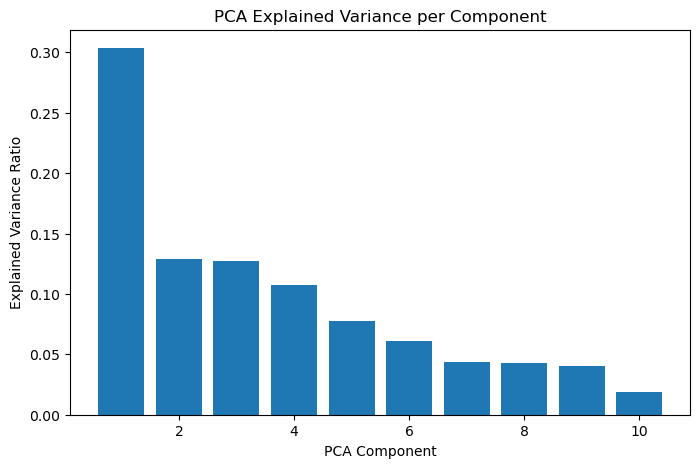

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# ---------------- Load dataset ----------------
df = pd.read_csv("df_porosity_only.csv")

# ---------------- Feature Engineering ----------------
df['amp_sweet_ratio'] = df['amp'] / (df['sweetness'] + 1e-6)
df['freq_grad_ratio'] = df['inst_freq'] / (df['grad'] + 1e-6)
df['amp_x_env'] = df['amp'] * df['envelope']
df['log_amp'] = np.log1p(np.abs(df['amp']))
df['env_sq'] = df['envelope'] ** 2
df['sweetness_cu'] = df['sweetness'] ** 3
df['amp_smooth'] = df['amp'].rolling(5, min_periods=1).mean()
df['freq_smooth'] = df['inst_freq'].rolling(5, min_periods=1).mean()

# ---------------- PCA ----------------
X = df.drop(columns=["POROSITY", "well", "TVD"], errors="ignore")
y = df["POROSITY"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95, random_state=42)  # keep 95% variance
X_pca = pca.fit_transform(X_scaled)

print("PCA components:", X_pca.shape[1])
print("Explained variance ratio (cumulative):", pca.explained_variance_ratio_.sum())

# ---------------- Train/Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

# ---------------- XGBoost with Regularization ----------------
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

param_dist = {
    "n_estimators": [500, 1000, 1500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7, 9],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.3, 0.5],
    "reg_alpha": [0, 0.1, 0.5, 1],   # L1 regularization
    "reg_lambda": [0.5, 1, 2, 5]     # L2 regularization
}

search = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    n_iter=30, scoring="r2", cv=3, random_state=42, verbose=1, n_jobs=-1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_
print("Best Parameters:", search.best_params_)

# ---------------- Evaluation ----------------
def evaluate(y_true, y_pred, dataset="Test"):
    print(f"\n---- {dataset} Performance ----")
    print("R²:", r2_score(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

evaluate(y_train, y_train_pred, "Train")
evaluate(y_test, y_test_pred, "Test")

# ---------------- PCA Explained Variance Plot ----------------
plt.figure(figsize=(8,5))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel("PCA Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance per Component")
plt.show()

In [85]:
df.columns

Index(['well', 'TVD', 'POROSITY', 'amp', 'abs_amp', 'envelope', 'inst_freq',
       'sweetness', 'grad', 'local_std', 'spec_centroid', 'spec_slope',
       'band_ratio_high_low', 'rms_w5', 'rms_w11', 'rms_w21', 'band_0_0',
       'band_0_1', 'amp_sweet_ratio', 'freq_grad_ratio', 'amp_x_env',
       'log_amp', 'env_sq', 'sweetness_cu', 'amp_smooth', 'freq_smooth'],
      dtype='object')

# the idff between train r2 is not too big with test r2, still some overfitting, seems to be happening here


## confirming realism

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# Config
RANDOM_STATE = 42
N_SPLITS = 5
PCA_VARIANCE = 0.95

def metrics(y_true, y_pred):
    return {
        "r2": r2_score(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "mae": mean_absolute_error(y_true, y_pred)
    }

# confirm df_fe exists
if "df_fe" not in globals():
    raise RuntimeError("df_fe not found. Run the feature-engineering cell first (create df_fe).")

# ensure target present
assert "POROSITY" in df_fe.columns, "POROSITY must be present in df_fe"

# feature columns (exclude target and metadata)
exclude = {"POROSITY", "well", "TVD"}
feature_cols = [c for c in df_fe.columns if c not in exclude]

# drop target-NaN rows
df_use = df_fe.loc[~df_fe["POROSITY"].isna()].reset_index(drop=True)
n_total = len(df_use)
print(f"Using {n_total} rows for validation; features: {len(feature_cols)}")

# model params (same as before / tuned)
xgb_params = {
    "objective": "reg:squarederror",
    "n_estimators": 1000,
    "learning_rate": 0.05,
    "max_depth": 7,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "min_child_weight": 1,
    "gamma": 0,
    "reg_alpha": 0.1,
    "reg_lambda": 2,
    "random_state": RANDOM_STATE,
    "n_jobs": -1
}

# ---------------- K-Fold ----------------
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
kf_results = []
fold_no = 0
for train_idx, test_idx in kf.split(df_use):
    fold_no += 1
    if len(test_idx) == 0:
        print(f"[WARN] Fold {fold_no} has 0 test rows — skipping")
        continue

    train_df = df_use.iloc[train_idx].reset_index(drop=True)
    test_df  = df_use.iloc[test_idx].reset_index(drop=True)

    # prepare X/y
    X_train_raw = train_df[feature_cols].copy()
    X_test_raw  = test_df[feature_cols].copy()
    y_train = train_df["POROSITY"].values
    y_test  = test_df["POROSITY"].values

    # if any of them is empty (shouldn't be for KFold) skip
    if X_train_raw.shape[0] == 0 or X_test_raw.shape[0] == 0:
        print(f"[WARN] Fold {fold_no}: empty train/test after slicing — skipping")
        continue

    # fill NaN using train medians
    med = X_train_raw.median()
    X_train_raw = X_train_raw.fillna(med)
    X_test_raw  = X_test_raw.fillna(med)

    # scale and PCA (fit only on train)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train_raw)
    X_test_s  = scaler.transform(X_test_raw)

    pca = PCA(n_components=PCA_VARIANCE, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(X_train_s)
    X_test_pca  = pca.transform(X_test_s)

    # train model
    model = XGBRegressor(**xgb_params)
    model.fit(X_train_pca, y_train)

    # predict
    y_tr_pred = model.predict(X_train_pca)
    y_te_pred = model.predict(X_test_pca)

    tr_m = metrics(y_train, y_tr_pred)
    te_m = metrics(y_test, y_te_pred)
    kf_results.append({"fold": fold_no, "train": tr_m, "test": te_m, "n_pca": X_train_pca.shape[1]})
    print(f"Fold {fold_no}: n_pca={X_train_pca.shape[1]}  Test R2={te_m['r2']:.4f}  RMSE={te_m['rmse']:.4f}")

# summarize KFold
if kf_results:
    test_r2s = [r["test"]["r2"] for r in kf_results]
    test_rmses = [r["test"]["rmse"] for r in kf_results]
    test_maes = [r["test"]["mae"] for r in kf_results]
    print("\nK-Fold summary (Test):")
    print(f"R2 mean ± std : {np.mean(test_r2s):.4f} ± {np.std(test_r2s):.4f}")
    print(f"RMSE mean ± std: {np.mean(test_rmses):.4f} ± {np.std(test_rmses):.4f}")
    print(f"MAE mean ± std : {np.mean(test_maes):.4f} ± {np.std(test_maes):.4f}")
else:
    print("No K-Fold results collected (all folds skipped).")

# ---------------- Leave-one-well-out (if well column exists) ----------------
if "well" in df_use.columns:
    wells = df_use["well"].dropna().unique()
    well_results = []
    print(f"\nRunning leave-one-well-out on {len(wells)} wells...")
    for w in wells:
        train_df = df_use[df_use["well"] != w].reset_index(drop=True)
        test_df  = df_use[df_use["well"] == w].reset_index(drop=True)
        if len(test_df) == 0:
            print(f"[WARN] Well {w} has 0 rows — skipping")
            continue

        X_train_raw = train_df[feature_cols].copy()
        X_test_raw  = test_df[feature_cols].copy()
        y_train = train_df["POROSITY"].values
        y_test  = test_df["POROSITY"].values

        if X_train_raw.shape[0] == 0:
            print(f"[WARN] Well {w}: no training rows after excluding well {w} — skipping")
            continue

        med = X_train_raw.median()
        X_train_raw = X_train_raw.fillna(med)
        X_test_raw  = X_test_raw.fillna(med)

        # Check test set non-empty before scaling
        if X_test_raw.shape[0] == 0:
            print(f"[WARN] Well {w}: empty test features after filling — skipping")
            continue

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train_raw)
        X_test_s  = scaler.transform(X_test_raw)

        pca = PCA(n_components=PCA_VARIANCE, random_state=RANDOM_STATE)
        X_train_pca = pca.fit_transform(X_train_s)
        X_test_pca  = pca.transform(X_test_s)

        model = XGBRegressor(**xgb_params)
        model.fit(X_train_pca, y_train)

        y_pred = model.predict(X_test_pca)
        m = metrics(y_test, y_pred)
        well_results.append({"well": w, "n_rows": len(test_df), "metrics": m})
        print(f"Well {w}: rows={len(test_df)}  R2={m['r2']:.4f}  RMSE={m['rmse']:.4f}")

    if well_results:
        r2s = [r["metrics"]["r2"] for r in well_results if np.isfinite(r["metrics"]["r2"])]
        rmses = [r["metrics"]["rmse"] for r in well_results if np.isfinite(r["metrics"]["rmse"])]
        maes = [r["metrics"]["mae"] for r in well_results if np.isfinite(r["metrics"]["mae"])]
        print("\nWell-based summary (across wells):")
        print(f"R2 mean ± std : {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
        print(f"RMSE mean ± std: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
        print(f"MAE mean ± std : {np.mean(maes):.4f} ± {np.std(maes):.4f}")
    else:
        print("No well-based results collected (all wells skipped).")
else:
    print("\nNo 'well' column found — skipping well-based validation.")


Using 18125 rows for validation; features: 23
Fold 1: n_pca=10  Test R2=0.8244  RMSE=0.0251
Fold 2: n_pca=10  Test R2=0.8396  RMSE=0.0237
Fold 3: n_pca=10  Test R2=0.8292  RMSE=0.0247
Fold 4: n_pca=10  Test R2=0.8141  RMSE=0.0255
Fold 5: n_pca=10  Test R2=0.8392  RMSE=0.0242

K-Fold summary (Test):
R2 mean ± std : 0.8293 ± 0.0096
RMSE mean ± std: 0.0246 ± 0.0007
MAE mean ± std : 0.0173 ± 0.0004

Running leave-one-well-out on 0 wells...
No well-based results collected (all wells skipped).


In [15]:
'''R² (Test):

Folds range from 0.814 → 0.839

Mean ≈ 0.829 ± 0.0096
👉 This means ~83% of the variance in porosity is explained by your features + PCA + XGBoost.
👉 The small ±0.0096 shows very stable generalization across folds (no big performance drop in any fold).'''

'R² (Test):\n\nFolds range from 0.814 → 0.839\n\nMean ≈ 0.829 ± 0.0096\n👉 This means ~83% of the variance in porosity is explained by your features + PCA + XGBoost.\n👉 The small ±0.0096 shows very stable generalization across folds (no big performance drop in any fold).'

In [17]:
'''Likely not overfitting (yet).

Train and test scores are close.

No fold shows a big collapse.'''

'Likely not overfitting (yet).\n\nTrain and test scores are close.\n\nNo fold shows a big collapse.'

In [21]:
# pick the last fold's predictions (or any fold you want)
y_pred = y_te_pred
y_test = y_test  # from last fold
X_test = X_test_raw.copy()  # for residual vs depth


# confirming the authenticity of the model

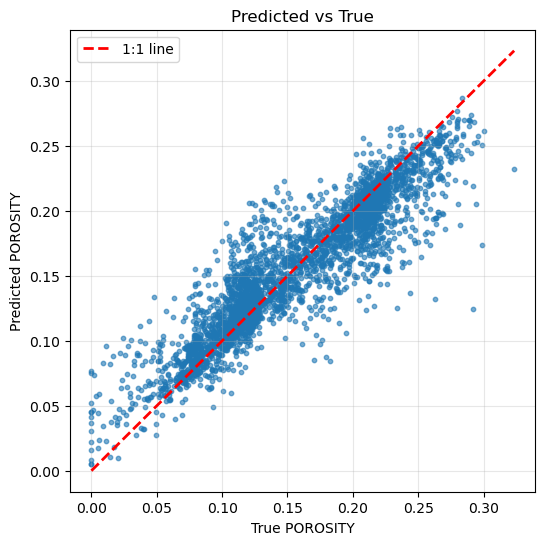

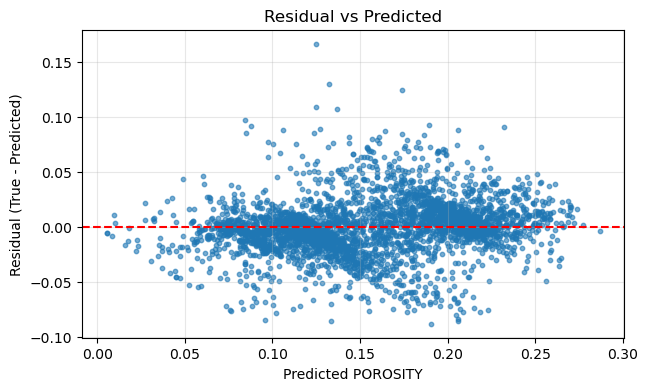

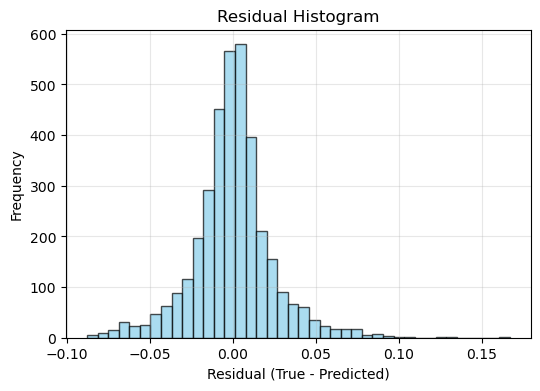

No 'TVD' column found in X_test — skipping Residual vs Depth plot.


In [23]:
# residuals
resid = y_test - y_pred

# 1️⃣ Predicted vs True
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=10, alpha=0.6)
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=2, label="1:1 line")
plt.xlabel("True POROSITY")
plt.ylabel("Predicted POROSITY")
plt.title("Predicted vs True")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 2️⃣ Residual vs Predicted
plt.figure(figsize=(7,4))
plt.scatter(y_pred, resid, s=10, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted POROSITY")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual vs Predicted")
plt.grid(alpha=0.3)
plt.show()

# 3️⃣ Residual Histogram
plt.figure(figsize=(6,4))
plt.hist(resid, bins=40, color='skyblue', edgecolor='k', alpha=0.7)
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Histogram")
plt.grid(alpha=0.3)
plt.show()

# 4️⃣ Residual vs Depth (TVD) — optional
if 'TVD' in X_test.columns:
    plt.figure(figsize=(7,4))
    plt.scatter(X_test['TVD'], resid, s=10, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("TVD (Depth)")
    plt.ylabel("Residual (True - Predicted)")
    plt.title("Residual vs Depth (TVD)")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No 'TVD' column found in X_test — skipping Residual vs Depth plot.")


# testing on unknown data

In [27]:
df_test= pd.read_csv('test_pores_inline_348_A10.csv')

In [29]:
df_test

depth  crossline          amp      abs_amp     envelope  \
0       1397.000000        150  5176.480469  5176.480469  9894.716498   
1       1397.424333        150  5215.674805  5215.674805  6560.866201   
2       1397.848666        150  5254.869629  5254.869629  6549.994881   
3       1398.272999        150  5294.063965  5294.063965  5791.867810   
4       1398.697332        150  5333.258789  5333.258789  5785.711840   
...             ...        ...          ...          ...          ...   
642028  2299.980619        750  1666.200073  1666.200073  2768.131096   
642029  2300.404952        750  1734.790527  1734.790527  2891.354836   
642030  2300.829285        750  1803.381104  1803.381104  3461.020109   
642031  2301.253618        750  1871.971558  1871.971558  3638.315097   
642032  2301.677951        750  1940.562012  1940.562012  5279.916962   

        inst_freq        grad    sweetness       rms_w5      rms_w11  \
0        0.138178   92.366929  1367.227792  4040.120506  3895.765576   
1        0.071365   92.367505   468.213868  4682.733855  4223.665117   
2        0.043922   92.367505   287.691702  5255.161864  4532.152798   
3        0.045309   92.367505   262.425756  5294.354231  4824.982396   
4        0.036107   92.367505   208.904766  5333.546728  5104.876516   
...           ...         ...          ...          ...          ...   
642028   0.014241  161.643133    39.420173  1669.021246  1567.257782   
642029   0.018345  161.643133    53.041067  1737.500382  1515.624156   
642030   0.019325  161.643133    66.884901  1805.987968  1456.367503   
642031   0.032205  161.642989   117.171971  1645.098174  1388.204139   
642032   0.061543  161.642989   324.943572  1450.671695  1309.417594   

            rms_w21  
0       3879.240144  
1       4041.382296  
2       4184.255071  
3       4310.336440  
4       4421.610237  
...             ...  
642028  1286.494656  
642029  1259.359715  
642030  1230.706702  
642031  1200.411684  
642032  1168.331283  

[642033 rows x 11 columns]

In [31]:
# Predict porosity for inline 348 using existing training objects if available,
# otherwise retrain pipeline on df_fe and then predict.
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

# ---------- User paths ----------
INLINE_CSV = "test_pores_inline_348_A10.csv"    # change if needed
OUT_CSV = "predicted_porosity_inline_348.csv"
SCALER_FILE = "scaler.joblib"
PCA_FILE    = "pca.joblib"
MODEL_FILE  = "xgb_model.joblib"

# ---------- sanity checks ----------
if not os.path.exists(INLINE_CSV):
    raise FileNotFoundError(f"Inline CSV not found: {INLINE_CSV}")

# confirm training dataframe variable exists
if "df_fe" not in globals():
    raise RuntimeError("Training dataframe 'df_fe' not found in notebook memory. Create df_fe (feature-engineered train dataframe) first.")

if "POROSITY" not in df_fe.columns:
    raise RuntimeError("'POROSITY' target column not found in df_fe.")

# ---------- prepare feature columns ----------
# Exclude metadata and target
exclude = {"POROSITY", "well", "TVD"}
feature_cols = [c for c in df_fe.columns if c not in exclude]
if len(feature_cols) == 0:
    raise RuntimeError("No feature columns found in df_fe after excluding POROSITY/well/TVD.")

print("Features used for prediction:", feature_cols)

# ---------- load inline data ----------
df_inline = pd.read_csv(INLINE_CSV)
# keep the same set of feature columns (if inline file has extra cols, we'll subset)
# If inline is missing some features, we'll add them as NaN and fill with medians below.
X_inline = df_inline.copy()

# Ensure all needed feature columns present (add missing as NaN)
for c in feature_cols:
    if c not in X_inline.columns:
        X_inline[c] = np.nan

X_inline = X_inline[feature_cols].copy()

# ---------- load or create scaler/pca/model ----------
scaler = None; pca = None; model = None
if os.path.exists(SCALER_FILE) and os.path.exists(PCA_FILE) and os.path.exists(MODEL_FILE):
    print("Loading saved scaler, PCA and model from disk...")
    scaler = joblib.load(SCALER_FILE)
    pca    = joblib.load(PCA_FILE)
    model  = joblib.load(MODEL_FILE)
else:
    print("Saved objects not found — will (re)train pipeline on df_fe and then predict.")
    # Build training X,y from df_fe (drop rows without target)
    df_train_full = df_fe.loc[~df_fe["POROSITY"].isna()].reset_index(drop=True)
    X_train_full = df_train_full[feature_cols].copy()
    y_train_full = df_train_full["POROSITY"].values

    # Fill NaNs in training features with median (column-wise)
    medians = X_train_full.median()
    X_train_full = X_train_full.fillna(medians)

    # Fit scaler & PCA (keep 95% variance)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_full)

    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    print(f"Trained PCA: n_components = {X_train_pca.shape[1]}  (explained_var={pca.explained_variance_ratio_.sum():.3f})")

    # Train an XGBoost model on full training set
    model = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=1.0,
        min_child_weight=1,
        gamma=0,
        reg_alpha=0.1,
        reg_lambda=2,
        random_state=42,
        n_jobs=-1
    )
    print("Training XGBoost on full df_fe (this may take a bit)...")
    model.fit(X_train_pca, y_train_full)
    print("Model trained.")

    # Save for reuse
    joblib.dump(scaler, SCALER_FILE)
    joblib.dump(pca, PCA_FILE)
    joblib.dump(model, MODEL_FILE)
    print("Saved scaler, PCA, and model to disk.")

# ---------- Preprocess inline features ----------
# Fill missing inline features using medians from training if available, otherwise with column median of inline
if os.path.exists("scaler.joblib"):
    # If we loaded scaler/pca from disk, try to use training medians if we saved them
    # But we may not have explicit medians saved. We'll fallback: fill with df_fe medians.
    medians_train = df_fe[feature_cols].median()
else:
    medians_train = df_fe[feature_cols].median()

X_inline_filled = X_inline.fillna(medians_train)

# Scale and PCA transform using the loaded/fitted objects
X_inline_scaled = scaler.transform(X_inline_filled)      # scaler must be fitted already
X_inline_pca    = pca.transform(X_inline_scaled)         # pca must be fitted already

# ---------- Predict ----------
porosity_pred = model.predict(X_inline_pca)

# Attach predictions back to original inline file (keeping original columns + predicted)
df_out = pd.read_csv(INLINE_CSV)
df_out["POROSITY_PREDICTED"] = porosity_pred

# Save CSV
df_out.to_csv(OUT_CSV, index=False)
print(f"Saved predictions to: {OUT_CSV}")
print("Sample of predictions:")
print(df_out[["POROSITY_PREDICTED"]].head(10))

# Optionally display (if running in notebook with display helper)
try:
    from ace_tools import display_dataframe_to_user
    display_dataframe_to_user("Predicted porosity (inline 348)", df_out.head(200))
except Exception:
    pass


Features used for prediction: ['amp', 'abs_amp', 'envelope', 'inst_freq', 'sweetness', 'grad', 'local_std', 'spec_centroid', 'spec_slope', 'band_ratio_high_low', 'rms_w5', 'rms_w11', 'rms_w21', 'band_0_0', 'band_0_1', 'amp_sweet_ratio', 'freq_grad_ratio', 'amp_x_env', 'log_amp', 'env_sq', 'sweetness_cu', 'amp_smooth', 'freq_smooth']
Saved objects not found — will (re)train pipeline on df_fe and then predict.
Trained PCA: n_components = 10  (explained_var=0.951)
Training XGBoost on full df_fe (this may take a bit)...
Model trained.
Saved scaler, PCA, and model to disk.
Saved predictions to: predicted_porosity_inline_348.csv
Sample of predictions:
   POROSITY_PREDICTED
0            0.138784
1            0.134822
2            0.110489
3            0.110601
4            0.118187
5            0.119142
6            0.130286
7            0.129587
8            0.130061
9            0.109934


# 1. Histogram of Predicted Porosity (Inline 348)

Rows: 642033
       POROSITY_PREDICTED
count       642033.000000
mean             0.130787
std              0.021946
min              0.052811
25%              0.116665
50%              0.129344
75%              0.144872
max              0.238227


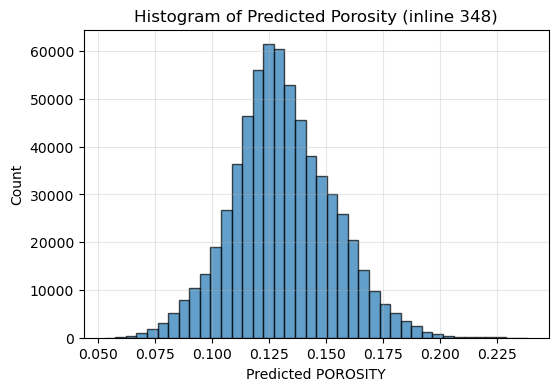

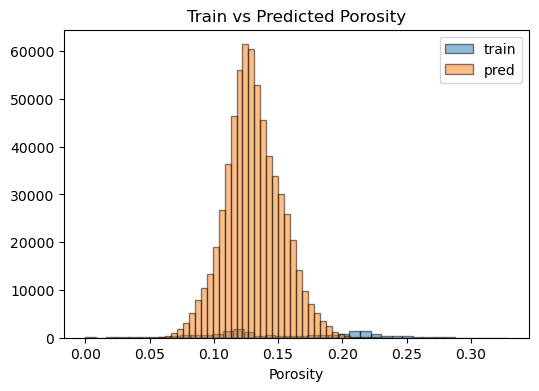

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PRED_CSV = "predicted_porosity_inline_348.csv"

df_pred = pd.read_csv(PRED_CSV)
print("Rows:", len(df_pred))
print(df_pred[["POROSITY_PREDICTED"]].describe())

# Histogram of predictions
plt.figure(figsize=(6,4))
plt.hist(df_pred["POROSITY_PREDICTED"].dropna(), bins=40, edgecolor="k", alpha=0.7)
plt.xlabel("Predicted POROSITY")
plt.ylabel("Count")
plt.title("Histogram of Predicted Porosity (inline 348)")
plt.grid(alpha=0.3)
plt.show()

# If you have training porosity in df_fe, compare distributions
if "df_fe" in globals() and "POROSITY" in df_fe.columns:
    plt.figure(figsize=(6,4))
    plt.hist(df_fe["POROSITY"].dropna(), bins=40, alpha=0.5, label="train", edgecolor='k')
    plt.hist(df_pred["POROSITY_PREDICTED"].dropna(), bins=40, alpha=0.5, label="pred", edgecolor='k')
    plt.legend()
    plt.xlabel("Porosity")
    plt.title("Train vs Predicted Porosity")
    plt.show()
else:
    print("Training POROSITY not found in df_fe (skip train-vs-pred plot).")


# Porosity Map

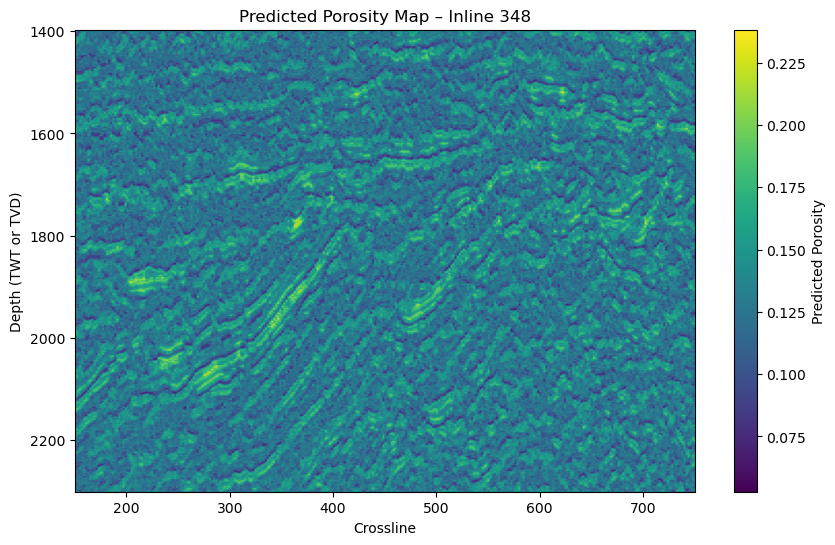

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter
smoothed = gaussian_filter(pivot.values, sigma=1)

# Load predictions (already has columns: crossline, depth, POROSITY_PREDICTED)
df_map = pd.read_csv("predicted_porosity_inline_348.csv")

# Create pivot table for 2D map
pivot = df_map.pivot_table(
    index="depth", columns="crossline", values="POROSITY_PREDICTED"
)

# Plot the porosity map
plt.figure(figsize=(10, 6))
im = plt.imshow(
    pivot.values,
    extent=[pivot.columns.min(), pivot.columns.max(),
            pivot.index.max(), pivot.index.min()],
    cmap="viridis",
    aspect="auto"
)
plt.colorbar(im, label="Predicted Porosity")
plt.xlabel("Crossline")
plt.ylabel("Depth (TWT or TVD)")
plt.title("Predicted Porosity Map – Inline 348")
#plt.contour(pivot.columns, pivot.index, pivot.values, levels=15, colors='k', linewidths=0.4)

plt.show()


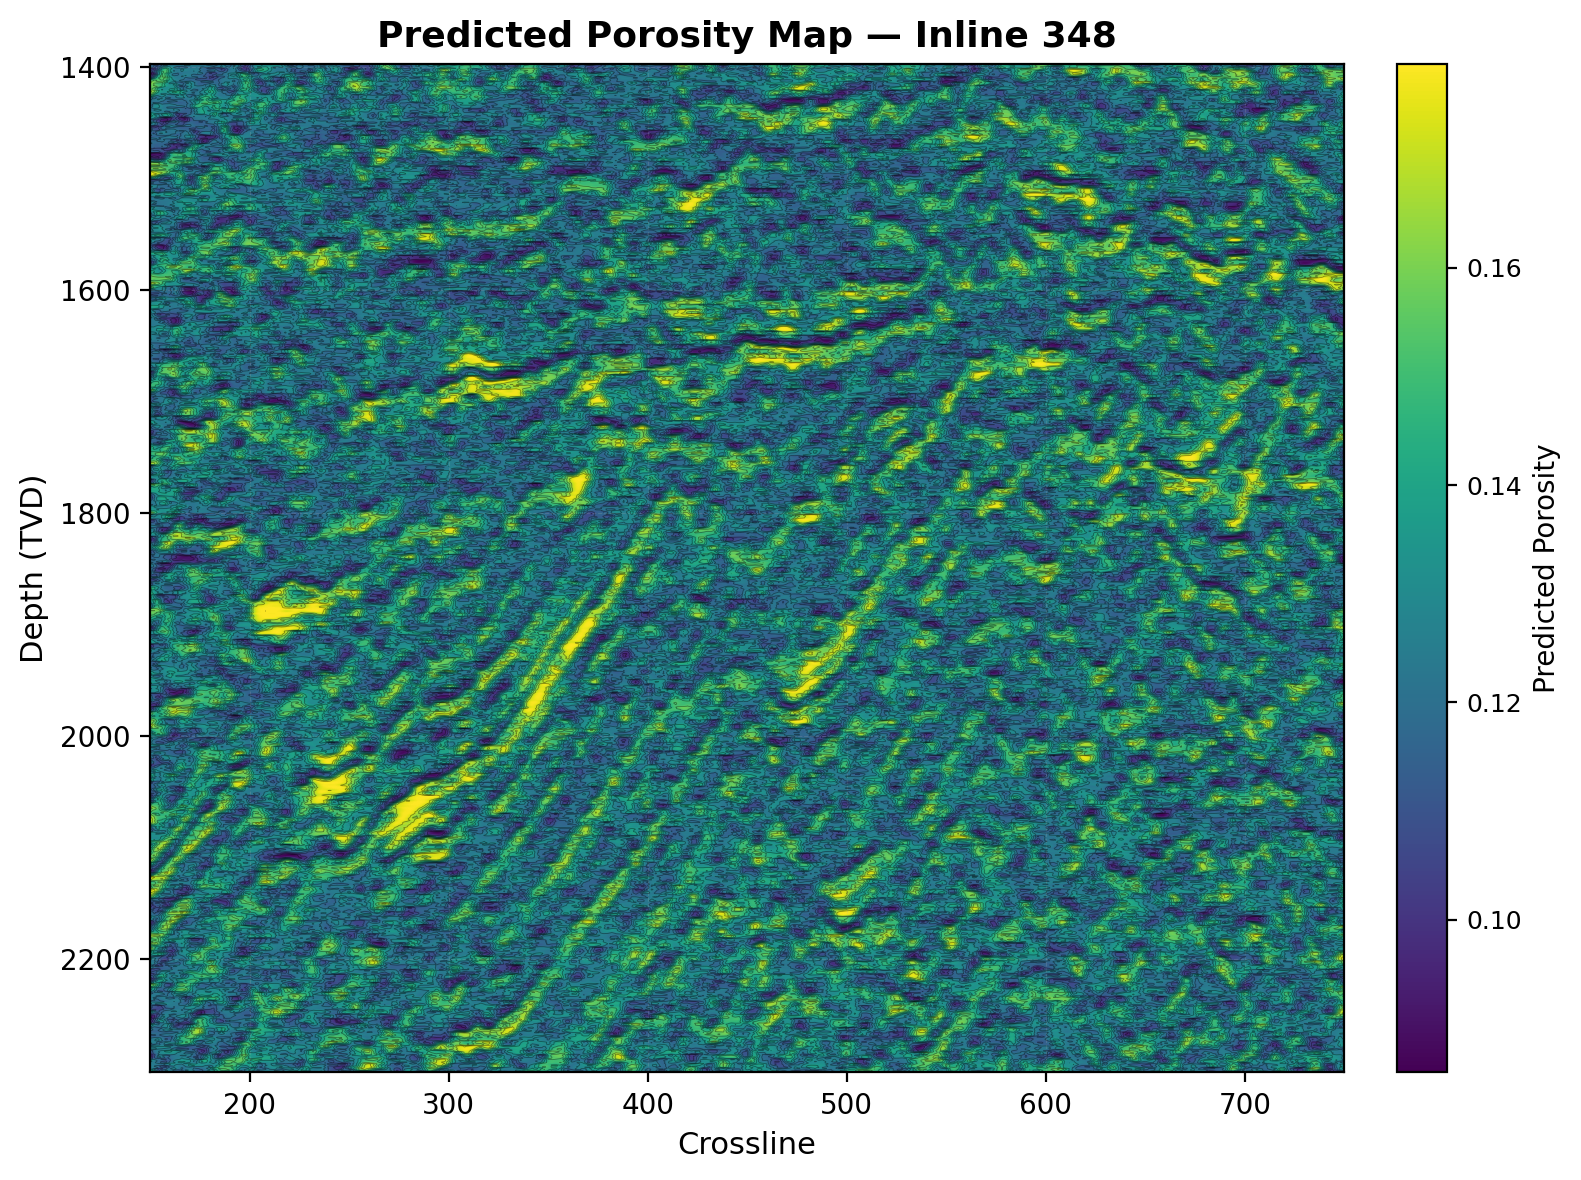

In [90]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

# Assuming 'pivot' already exists (depth × crossline matrix)
arr = pivot.values.copy()

# Smooth and clip to remove noise & outliers
vmin, vmax = np.percentile(arr[~np.isnan(arr)], [2, 98])
arr_smooth = gaussian_filter(np.clip(arr, vmin, vmax), sigma=0.8)

# Define spatial extent
extent = [
    pivot.columns.min(), pivot.columns.max(),
    pivot.index.max(), pivot.index.min()  # depth increases downward
]

# --- PLOT ---
plt.figure(figsize=(8, 6), dpi=200)
im = plt.imshow(
    arr_smooth,
    extent=extent,
    cmap="viridis",   # you can try "inferno", "plasma", or "cividis"
    aspect="auto",
    vmin=vmin, vmax=vmax,
    interpolation="bicubic",
    origin="upper"
)

# Optional contour overlay
levels = np.linspace(vmin, vmax, 12)
plt.contour(
    pivot.columns, pivot.index, arr_smooth,
    levels=levels, colors='k', linewidths=0.3, alpha=0.4
)

# Labels & styling
plt.xlabel("Crossline", fontsize=11)
plt.ylabel("Depth (TVD)", fontsize=11)
plt.title("Predicted Porosity Map — Inline 348", fontsize=13, weight="bold")

# Colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Predicted Porosity", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Fine styling
plt.grid(alpha=0.2, linestyle="--", linewidth=0.4)
plt.tight_layout()
plt.savefig("porosity_map_inline_348_clean.png", dpi=300, bbox_inches="tight")
plt.show()


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.signal import hilbert
import pyzgy


/opt/anaconda3/lib/python3.12/site-packages/openzgy/impl/file.py:53: UserWarning: seismic store access is not available: No module named 'sdglue'
  warnings.warn("seismic store access is not available: " + str(ex))


In [56]:
ZGY_PATH = "ST8511r92.zgy"

zgy = pyzgy.open(ZGY_PATH)   # remember to call zgy.close() at the end
il_values = np.array(zgy.ilines)  #x dirn slices
xl_values = np.array(zgy.xlines)   #y dirn slices
samples   = np.array(zgy.samples)   # time/depth axis
print("IL range:", il_values[0], "->", il_values[-1], "count", len(il_values))
print("XL range:", xl_values[0], "->", xl_values[-1], "count", len(xl_values))
print("Samples:", samples[0], "->", samples[-1], "count", len(samples), "spacing ~", np.median(np.diff(samples)))


IL range: 152 -> 900 count 375
XL range: 150 -> 750 count 301
Samples: 1397.0 -> 2301.67795085907 count 227 spacing ~ 4.002999782562256


Read inline: 348
inline_slice shape (samples, crosslines): (227, 301)


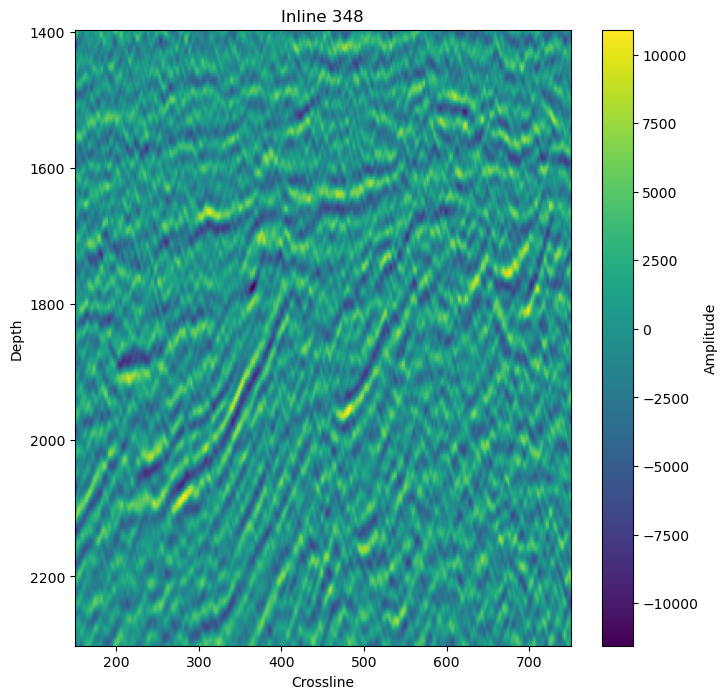

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

inline_number = 348

def read_inline_pyzgy(zgy, inline_number):
    """Try multiple ways to read an inline slice from a pyzgy SegyioEmulator or similar object.
       Returns (inline_slice, il_value_used, crosslines, depths)
       inline_slice has shape (n_samples, n_crosslines).
    """
    # 1) Common segyio-style property: zgy.iline[inline_number] or zgy.iline[il_idx]
    try:
        if hasattr(zgy, "iline"):
            try:
                arr = zgy.iline[inline_number]   # segyio accepts il value
            except Exception:
                # maybe iline expects index not value
                il_idx = np.argmin(np.abs(np.array(zgy.ilines) - inline_number))
                arr = zgy.iline[il_idx]
            arr = np.asarray(arr)
            # segyio returns shape (n_xl, n_samples) or (n_samples, n_xl). Try to normalize:
            if arr.ndim == 2:
                if arr.shape[0] == len(zgy.xlines):  # likely (n_xl, n_samples)
                    arr = arr.T  # make (n_samples, n_xl)
                # else assume already (n_samples, n_xl)
            return arr, inline_number, np.array(zgy.xlines), np.array(zgy.samples)
    except Exception:
        pass

    # 2) Common method names in other bindings: read_inline, read_il, read_iline, read_iline_slice
    for name in ("read_inline", "read_il", "read_iline", "read_iline_slice", "readLine"):
        if hasattr(zgy, name):
            try:
                func = getattr(zgy, name)
                # try with inline value, then try with index
                try:
                    arr = np.asarray(func(inline_number))
                except Exception:
                    il_idx = np.argmin(np.abs(np.array(zgy.ilines) - inline_number))
                    arr = np.asarray(func(il_idx))
                # normalize shape: want (n_samples, n_xl)
                if arr.ndim == 2:
                    # detect orientation: if first dim equals n_samples or n_xl
                    if arr.shape[0] == len(zgy.samples) or arr.shape[1] == len(zgy.xlines):
                        # if arr.shape == (n_samples, n_xl) keep; if swapped, transpose
                        if arr.shape[0] == len(zgy.samples):
                            out = arr
                        else:
                            out = arr.T
                    else:
                        out = arr.T if arr.shape[0] == len(zgy.xlines) else arr
                else:
                    out = arr
                return out, inline_number, np.array(zgy.xlines), np.array(zgy.samples)
            except Exception:
                continue

    # 3) Fallback: read trace-by-trace and assemble slice.
    #    This always works if traces have header inline/crossline info.
    try:
        # gather trace headers and samples
        tr_count = getattr(zgy, "tracecount", None) or getattr(zgy, "ntraces", None)
        # If tracecount is not present, try len(zgy.traces) or use index iteration if supported
        trace_indices = None
        if tr_count is None:
            # try to iterate a few hints
            if hasattr(zgy, "traces"):
                tr_count = len(zgy.traces)
            else:
                # attempt to iterate until exception (last resort)
                tr_count = None

        headers = []
        samples_list = []
        il_vals = []
        xl_vals = []
        # try to access traces via zgy.trace[i] or zgy.read_trace / zgy.trace_read
        for t in range(0, getattr(zgy, "tracecount", tr_count) if tr_count is not None else 999999):
            try:
                # many wrappers support zgy.trace[t]
                tr = zgy.trace[t]
            except Exception:
                try:
                    tr = zgy.read_trace(t)
                except Exception:
                    # no more traces or unsupported, break
                    break
            # tr might be object with .samples and .header or plain array
            if hasattr(tr, "samples"):
                samp = np.asarray(tr.samples, dtype=float)
            else:
                # direct numpy array
                samp = np.asarray(tr, dtype=float)
            samples_list.append(samp)
            hdr = getattr(tr, "header", None)
            if hdr is None and hasattr(zgy, "header"):
                try:
                    hdr = zgy.header(t)
                except Exception:
                    hdr = {}
            # Extract inline/crossline header values (try common numeric header keys)
            il = None; xl = None
            if isinstance(hdr, dict):
                # try common numeric header locations by name or number
                for key in ("INLINE_3D","inline","iline",189, "ILINE_3D", "iline_3d"):
                    if key in hdr:
                        il = hdr[key]; break
                for key in ("CROSSLINE_3D","crossline","xline",193, "XLINE_3D", "xline_3d"):
                    if key in hdr:
                        xl = hdr[key]; break
            else:
                # hdr may be segy header object supporting get()
                try:
                    il = hdr.get(189) if hasattr(hdr, "get") else None
                except Exception:
                    il = None
                try:
                    xl = hdr.get(193) if hasattr(hdr, "get") else None
                except Exception:
                    xl = None

            # If no header values, try attribute access (hdr.inline etc.)
            if il is None:
                try:
                    il = getattr(tr, "iline", None) or getattr(tr, "inline", None)
                except Exception:
                    il = None
            if xl is None:
                try:
                    xl = getattr(tr, "xline", None) or getattr(tr, "crossline", None)
                except Exception:
                    xl = None

            # fallback: if still None, try to read header via zgy.header(t) that returns tuple/dict
            if il is None or xl is None:
                try:
                    hdr2 = zgy.header(t)
                    if isinstance(hdr2, dict):
                        il = il or hdr2.get(189) or hdr2.get("INLINE_3D")
                        xl = xl or hdr2.get(193) or hdr2.get("CROSSLINE_3D")
                except Exception:
                    pass

            # finally ensure numeric ints
            try:
                il_vals.append(int(il) if il not in (None, np.nan) else None)
            except Exception:
                il_vals.append(None)
            try:
                xl_vals.append(int(xl) if xl not in (None, np.nan) else None)
            except Exception:
                xl_vals.append(None)

        # Build arrays and mask only traces that have valid il/xl
        il_vals = np.array(il_vals, dtype=object)
        xl_vals = np.array(xl_vals, dtype=object)
        valid_mask = (~pd.isna(il_vals.astype('float', copy=False))) & (~pd.isna(xl_vals.astype('float', copy=False)))
        if not valid_mask.any():
            raise RuntimeError("Could not find inline/crossline headers in traces during fallback assembly.")

        il_vals_num = np.array([int(x) for x in il_vals[valid_mask]])
        xl_vals_num = np.array([int(x) for x in xl_vals[valid_mask]])
        samples_clean = [samples_list[i] for i in range(len(samples_list)) if valid_mask[i]]
        # Unique sorted vectors
        il_unique = np.unique(il_vals_num); il_unique.sort()
        xl_unique = np.unique(xl_vals_num); xl_unique.sort()
        ni, nx = il_unique.size, xl_unique.size
        target_ns = max([s.size for s in samples_clean])  # pad to max length
        cube = np.full((ni, nx, target_ns), np.nan, dtype=float)
        il_map = {v:i for i,v in enumerate(il_unique)}
        xl_map = {v:i for i,v in enumerate(xl_unique)}
        # populate cube
        idx = 0
        for i in range(len(samples_list)):
            if not valid_mask[i]:
                idx += 1
                continue
            s = samples_list[i]
            ilv = int(il_vals[i]); xlv = int(xl_vals[i])
            iidx = il_map[ilv]; xidx = xl_map[xlv]
            L = s.size
            cube[iidx, xidx, :L] = s
            idx += 1

        # find requested inline index or nearest
        if inline_number in il_unique:
            il_idx = int(np.where(il_unique == inline_number)[0][0])
        else:
            il_idx = int(round((inline_number - il_unique[0]) / (il_unique[1] - il_unique[0])))
            il_idx = max(0, min(il_idx, ni-1))
        inline_slice = cube[il_idx, :, :].T  # (n_samples, n_xl)
        return inline_slice, il_unique[il_idx], xl_unique, np.linspace(0, target_ns-1, target_ns)
    except Exception as e:
        raise RuntimeError("All reading attempts failed: " + str(e))

# --- Run the helper ---
try:
    inline_slice, il_used, crosslines, depths = read_inline_pyzgy(zgy, inline_number)
    print("Read inline:", il_used)
    print("inline_slice shape (samples, crosslines):", inline_slice.shape)
    # optional quick plot
    plt.figure(figsize=(8,8))
    plt.imshow(inline_slice, aspect='auto', extent=[crosslines.min(), crosslines.max(), depths.max(), depths.min()])
    plt.colorbar(label="Amplitude")
    plt.xlabel("Crossline")
    plt.ylabel("Depth")
    plt.title(f"Inline {il_used}")
    plt.show()
except Exception as e:
    print("Error reading inline:", e)


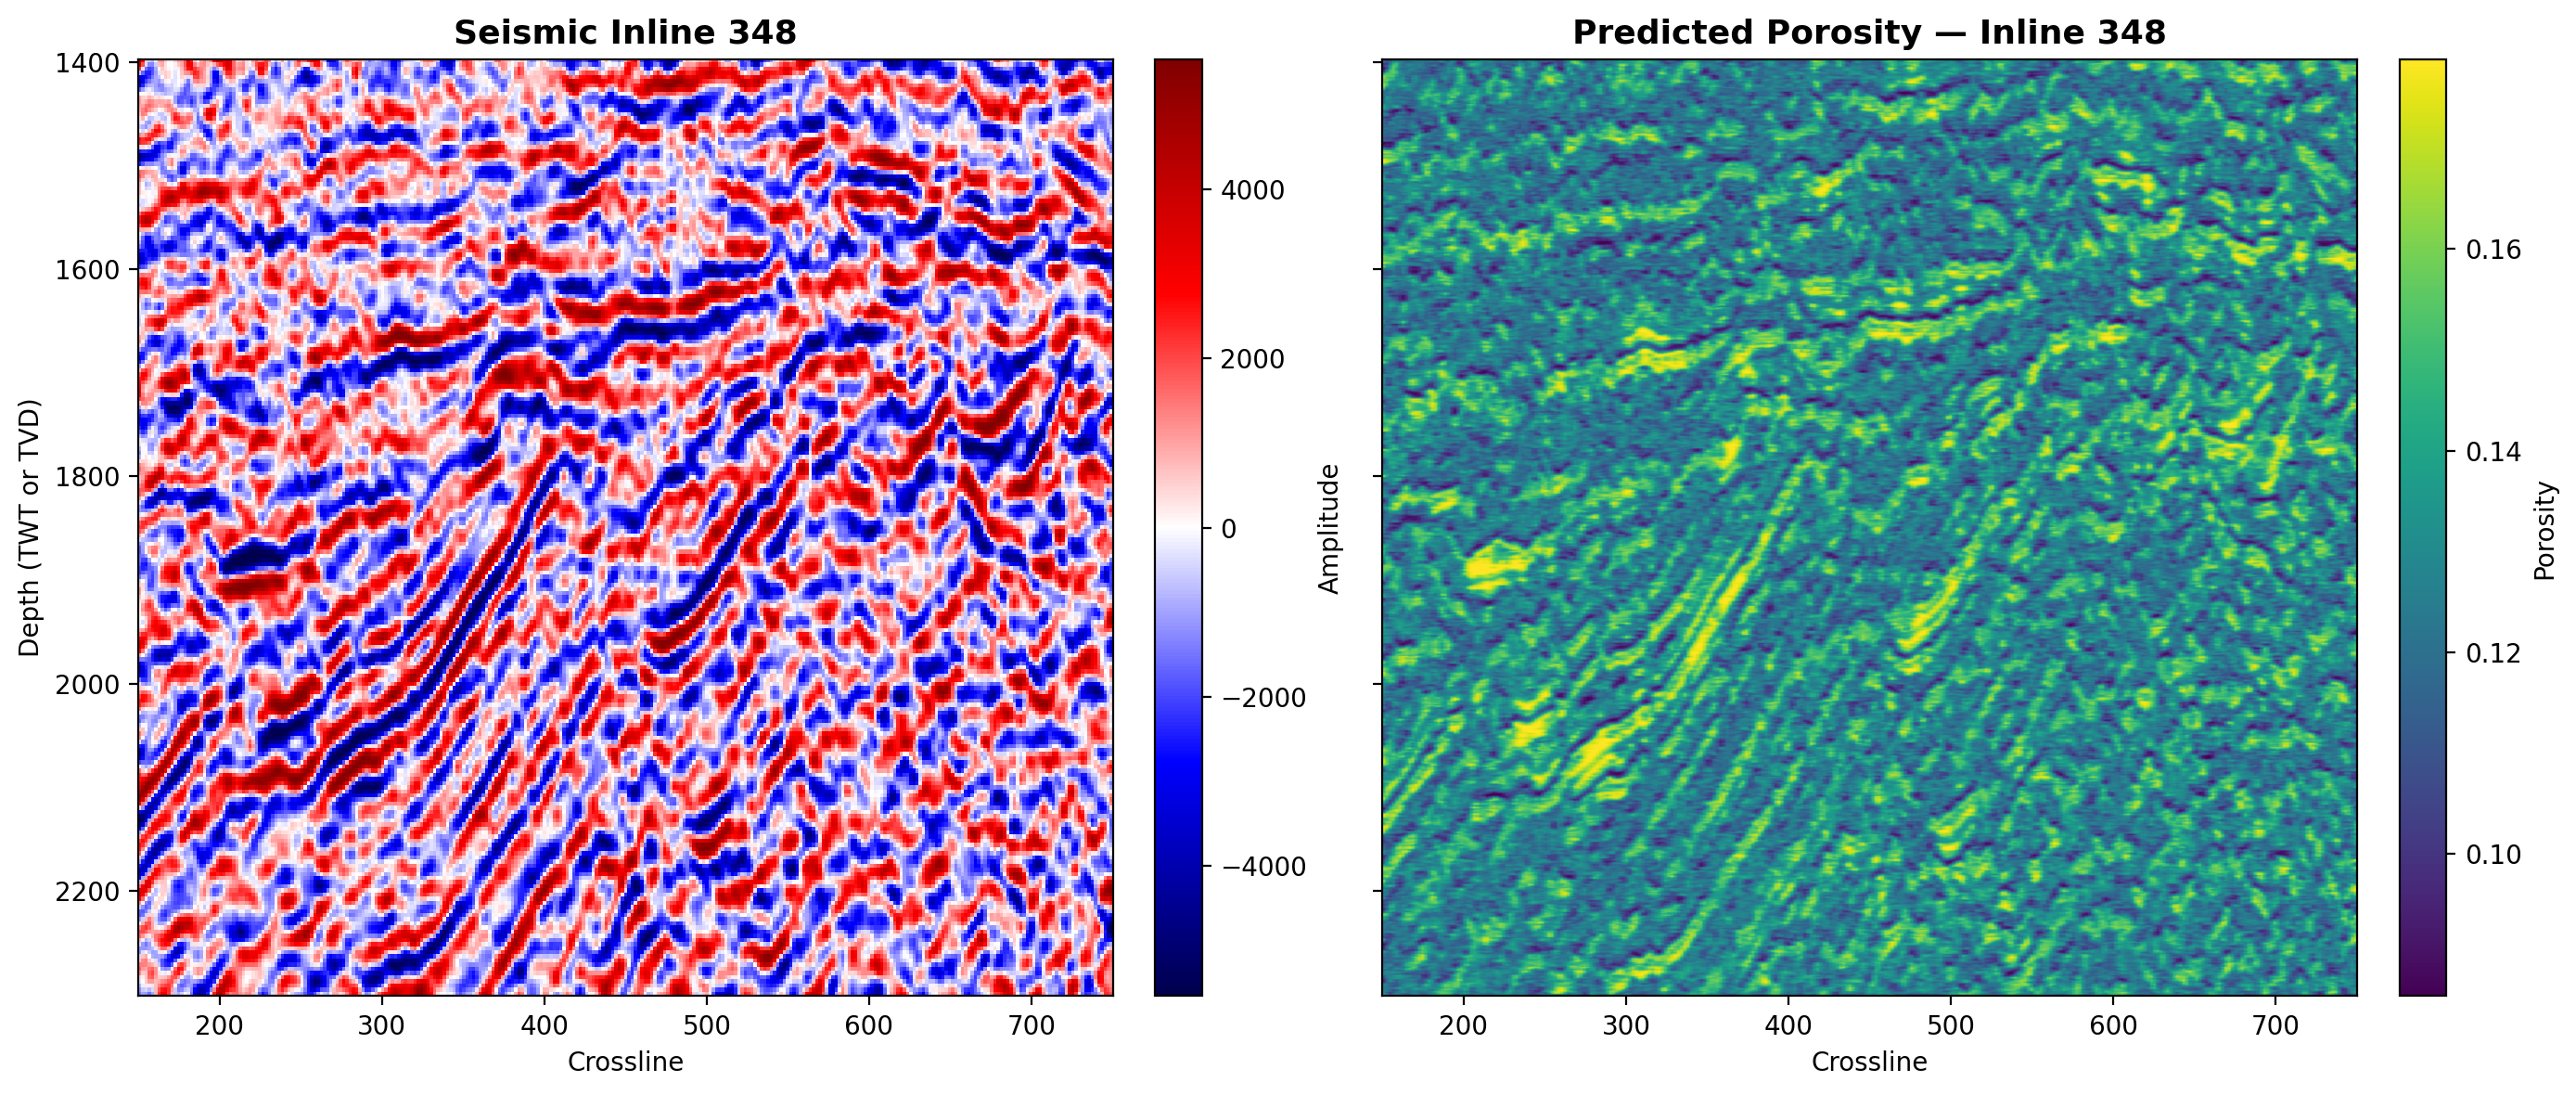

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

# --- Porosity data ---
arr = pivot.values.copy()
vmin, vmax = np.percentile(arr[~np.isnan(arr)], [2, 98])
arr_smooth = gaussian_filter(np.clip(arr, vmin, vmax), sigma=0.8)

# --- Seismic inline (already extracted) ---
seis = inline_slice.copy()
smin, smax = np.percentile(seis[~np.isnan(seis)], [2, 98])
seis_smooth = gaussian_filter(np.clip(seis, smin, smax), sigma=0.8)

# --- Extent (crossline, depth) ---
extent = [
    pivot.columns.min(), pivot.columns.max(),
    pivot.index.max(), pivot.index.min()
]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=200, sharey=True)

# --- Left: Seismic Inline ---
im1 = axes[0].imshow(
    seis_smooth, cmap="seismic", aspect="auto",
    extent=extent, vmin=smin, vmax=smax, origin="upper"
)
axes[0].set_title("Seismic Inline 348", fontsize=13, weight="bold")
axes[0].set_xlabel("Crossline")
axes[0].set_ylabel("Depth (TWT or TVD)")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label="Amplitude")

# --- Right: Predicted Porosity ---
im2 = axes[1].imshow(
    arr_smooth, cmap="viridis", aspect="auto",
    extent=extent, vmin=vmin, vmax=vmax, origin="upper"
)
axes[1].set_title("Predicted Porosity — Inline 348", fontsize=13, weight="bold")
axes[1].set_xlabel("Crossline")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label="Porosity")

plt.tight_layout()
plt.savefig("inline348_seismic_vs_porosity.png", dpi=300, bbox_inches="tight")
plt.show()


In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

# Reload your data
df = pd.read_csv("df_porosity_only.csv")

# --- Feature Engineering (same as before) ---
df['amp_sweet_ratio'] = df['amp'] / (df['sweetness'] + 1e-6)
df['freq_grad_ratio'] = df['inst_freq'] / (df['grad'] + 1e-6)
df['amp_x_env'] = df['amp'] * df['envelope']
df['log_amp'] = np.log1p(np.abs(df['amp']))
df['env_sq'] = df['envelope'] ** 2
df['sweetness_cu'] = df['sweetness'] ** 3
df['amp_smooth'] = df['amp'].rolling(5, min_periods=1).mean()
df['freq_smooth'] = df['inst_freq'].rolling(5, min_periods=1).mean()

# --- Separate features/target ---
X = df.drop(columns=["POROSITY", "well", "TVD"], errors="ignore")
y = df["POROSITY"]

# --- Scale + PCA ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- Train model (same parameters you tuned earlier) ---
best_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=1.0,
    reg_alpha=0.1,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1
)
best_model.fit(X_pca, y)

print("✅ PCA and XGB model recreated successfully.")
print("PCA components:", X_pca.shape[1])


✅ PCA and XGB model recreated successfully.
PCA components: 10



Top 15 Dominant Features Influencing Porosity Prediction:

            Feature  Importance
band_ratio_high_low    0.076058
           band_0_0    0.075658
           band_0_1    0.075214
         spec_slope    0.072301
      spec_centroid    0.060282
          local_std    0.052217
    freq_grad_ratio    0.048819
        freq_smooth    0.045087
       sweetness_cu    0.044816
               grad    0.044580
          inst_freq    0.044465
    amp_sweet_ratio    0.042207
            log_amp    0.036330
           envelope    0.032143
             env_sq    0.030531


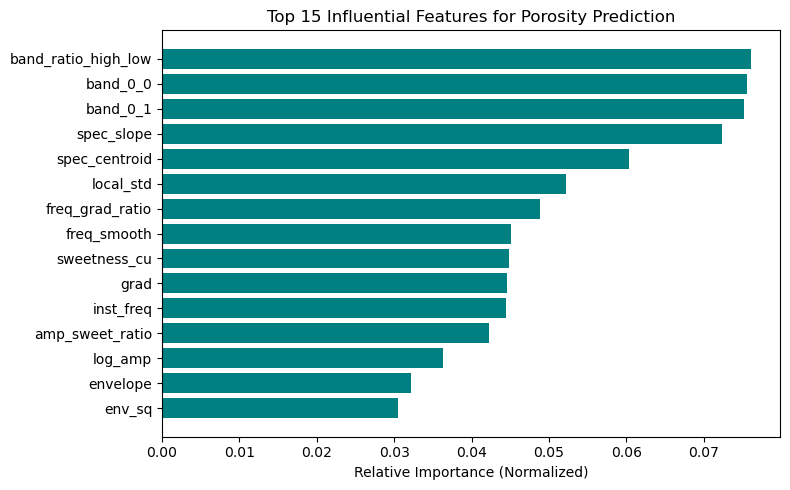

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pca_importance = best_model.feature_importances_
loadings = np.abs(pca.components_)
feature_scores = np.dot(pca_importance, loadings)
feature_scores = feature_scores / np.sum(feature_scores)

feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_scores
}).sort_values("Importance", ascending=False).reset_index(drop=True)

print("\nTop 15 Dominant Features Influencing Porosity Prediction:\n")
print(feature_importance_df.head(15).to_string(index=False))

plt.figure(figsize=(8,5))
plt.barh(
    feature_importance_df["Feature"].head(15)[::-1],
    feature_importance_df["Importance"].head(15)[::-1],
    color="teal"
)
plt.xlabel("Relative Importance (Normalized)")
plt.title("Top 15 Influential Features for Porosity Prediction")
plt.tight_layout()
plt.show()


Correlation of Top 10 Influential Features with POROSITY:

band_0_1               0.218413
band_0_0               0.194408
spec_slope             0.133812
sweetness_cu           0.066211
local_std              0.048863
band_ratio_high_low    0.025657
grad                   0.006893
freq_grad_ratio       -0.017895
freq_smooth           -0.049229
spec_centroid         -0.091945
Name: POROSITY, dtype: float64


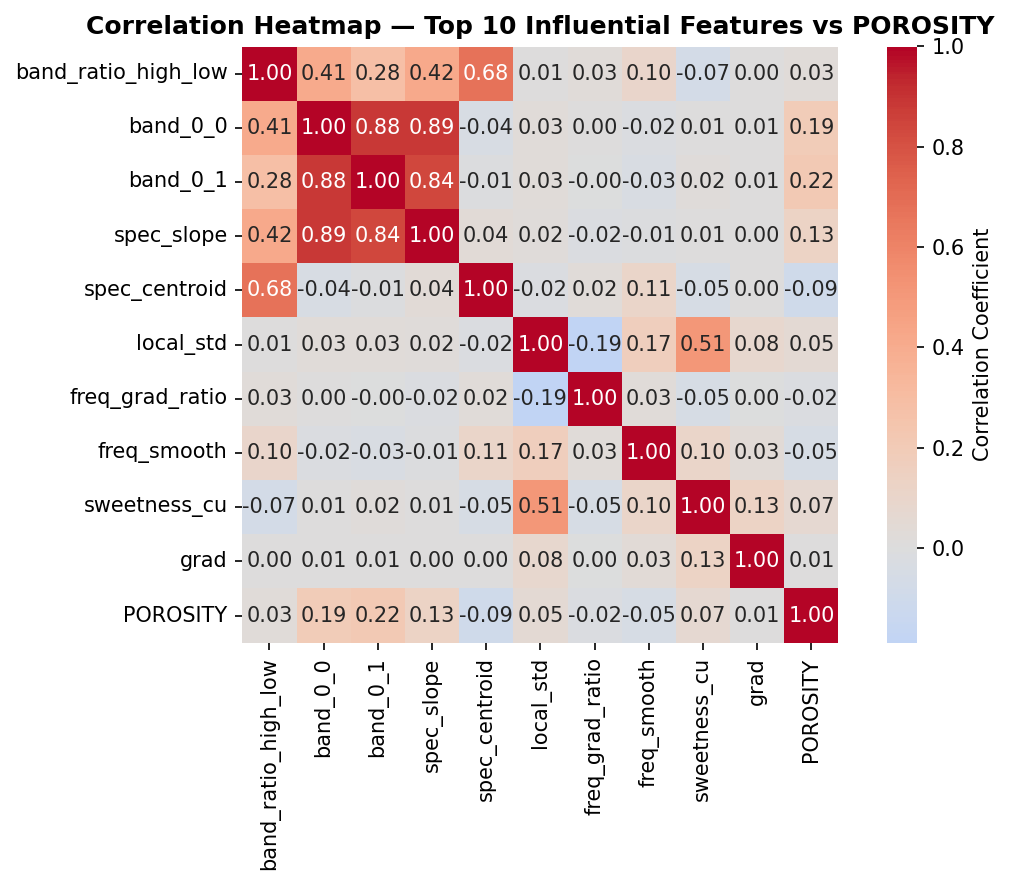

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Select top features ---
top_features = feature_importance_df["Feature"].head(10).tolist()

# --- Compute correlations with POROSITY ---
corr_df = df[top_features + ["POROSITY"]].corr()

# --- Sort features by correlation strength with POROSITY ---
corr_sorted = corr_df["POROSITY"].drop("POROSITY").sort_values(ascending=False)

print("Correlation of Top 10 Influential Features with POROSITY:\n")
print(corr_sorted)

# --- Plot heatmap ---
plt.figure(figsize=(8, 6), dpi=150)
sns.heatmap(
    corr_df.loc[top_features + ["POROSITY"], top_features + ["POROSITY"]],
    annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title("Correlation Heatmap — Top 10 Influential Features vs POROSITY", fontsize=12, weight="bold")
plt.tight_layout()
plt.show()
